In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

batch_size = 64
num_epochs = 15
learning_rates = [1e-2, 5e-3, 1e-3]
weight_decay = 5e-4

Подготовка данных

In [ ]:
transform = Compose([
    ToTensor(), 
    Normalize((0.1307,), (0.3081,))
])

#Загрузка MNIST
full_train_dataset = MNIST(root='.', train=True, transform=transform, download=True)
test_dataset = MNIST(root='.', train=False, transform=transform, download=True)

train_size = int(0.85 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Модель

In [7]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.fc(x)


class ReluLayer(nn.Module):
    def forward(self, x):
        return F.relu(x)


class SimpleMLP(nn.Module):
    def __init__(self, use_bn=False):
        super().__init__()
        self.seq = nn.Sequential(
            FullyConnectedLayer(784, 128),
            nn.BatchNorm1d(128) if use_bn else nn.Identity(),
            ReluLayer(),
            FullyConnectedLayer(128, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.seq(x)

In [8]:
class CustomAdam(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        defaults = dict(lr=lr, betas=betas, eps=eps)
        super().__init__(params, defaults)

    def step(self, closure=None):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Sparse gradients not supported by CustomAdam")

                state = self.state[p]
                if not state:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_c1 = 1 - beta1 ** state['step']
                bias_c2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * (bias_c2 ** 0.5) / bias_c1

                p.data.addcdiv_(exp_avg, denom, value=-step_size)

Тренировочный класс

In [9]:
class Trainer:
    def __init__(self, model, optimizer, loss_fn, l2=0.0):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.l2 = l2
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def train(self, train_loader, val_loader, epochs):
        train_losses, val_losses = [], []

        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            for x, y in train_loader:
                x, y = x.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(x)
                loss = self.loss_fn(logits, y) + self.l2 * sum(p.pow(2).sum() for p in self.model.parameters())
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            train_losses.append(total_loss / len(train_loader))

            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(self.device), y.to(self.device)
                    logits = self.model(x)
                    val_loss += self.loss_fn(logits, y).item()
            val_losses.append(val_loss / len(val_loader))

        return train_losses, val_losses

    def accuracy(self, loader):
        self.model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                preds = self.model(x).argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        return correct / total

Эксперимент

In [10]:
optimizers = {
    "CustomAdam": lambda params, lr: CustomAdam(params, lr=lr),
    "SGD": lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9)
}

results = {}

for opt_name, opt_fn in optimizers.items():
    for lr in learning_rates:
        tag = f"{opt_name}_lr={lr}"
        model = SimpleMLP(use_bn=True)
        optimizer = opt_fn(model.parameters(), lr)
        trainer = Trainer(model, optimizer, nn.CrossEntropyLoss(), l2=weight_decay)
        train_loss, val_loss = trainer.train(train_loader, val_loader, num_epochs)
        val_acc = trainer.accuracy(val_loader)
        results[tag] = {
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "trainer": trainer
        }
        print(f"{tag}: Val Accuracy = {val_acc:.4f}")

CustomAdam_lr=0.01: Val Accuracy = 0.9476
CustomAdam_lr=0.005: Val Accuracy = 0.9544
CustomAdam_lr=0.001: Val Accuracy = 0.9712
SGD_lr=0.01: Val Accuracy = 0.9722
SGD_lr=0.005: Val Accuracy = 0.9729
SGD_lr=0.001: Val Accuracy = 0.9634


Визуализация

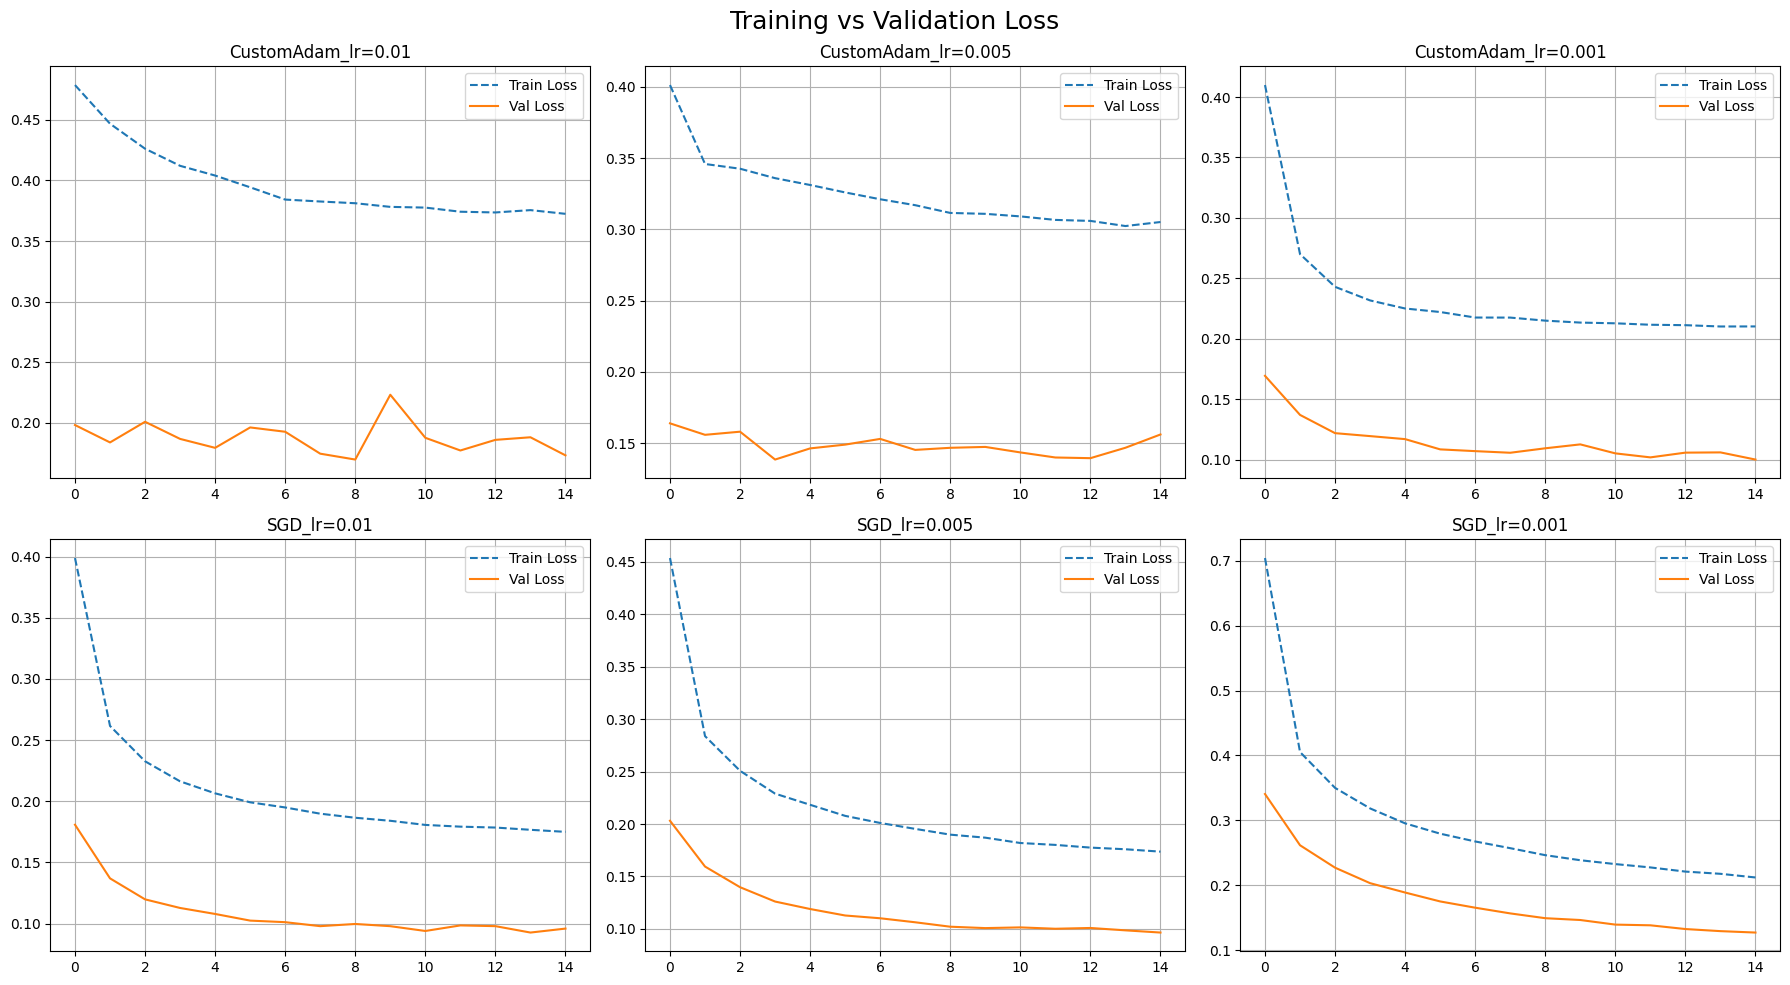

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, (tag, data) in enumerate(results.items()):
    axes[idx].plot(data["train_loss"], label="Train Loss", linestyle='--')
    axes[idx].plot(data["val_loss"], label="Val Loss")
    axes[idx].set_title(tag)
    axes[idx].grid(True)
    axes[idx].legend()

plt.suptitle("Training vs Validation Loss", fontsize=18)
plt.tight_layout()
plt.show()

Проверка 

In [12]:
for tag, data in results.items():
    test_acc = data["trainer"].accuracy(test_loader)
    data["test_acc"] = test_acc
    print(f"{tag}: Test Accuracy = {test_acc:.4f}")

CustomAdam_lr=0.01: Test Accuracy = 0.9509
CustomAdam_lr=0.005: Test Accuracy = 0.9580
CustomAdam_lr=0.001: Test Accuracy = 0.9746
SGD_lr=0.01: Test Accuracy = 0.9736
SGD_lr=0.005: Test Accuracy = 0.9748
SGD_lr=0.001: Test Accuracy = 0.9676


Вывод:

Наилучшую точность набирает модель с параметрами.

•  learning rate = 0.005
•  optimizer = SGD
•  и с использованием Batch Normalization (как и во всех остальных моделях).